# Confidence interval around quantiles

There seems to be a few ways to get confidence intervals around quantiles. I think that our confidence intervals for extreme precipitation will be very narrow because of our large sample size. Even the 99th percentile should be fine, but I want to make sure.

In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
from importlib import import_module
import esmlab

import scipy.stats as stats  # going to use stats.mstats.mquantiles_cimj

to_import = "/Users/brianpm/Code/yellowstone/py"
current_path = sys.path
if to_import not in current_path:
    sys.path.append(to_import)
import extreme_precipitation_functions as prf  # get_duration_and_size(events)
import cmip_file_utils as cmip  # quick_load_var(loc, var, table, model, experiment, member)

In [5]:
# how to reload:
from importlib import reload
reload(sys.modules['cmip_file_utils'])
import cmip_file_utils as cmip

In [2]:
def get_tropics_quantiles(da, threshold=None, q=0.99):
    da_tropics = da.sel(lat=slice(-30, 30))  # SHOULD BE ADJUSTABLE
    da_tropics_val = np.nanquantile(da_tropics, q)
    if threshold is not None:
        da_climo = da.mean(dim="time")
        da_process = np.where(
            (da_climo >= threshold).sel(lat=slice(-30, 30)).broadcast_like(da_tropics),
            da_tropics,
            np.nan,
        )
        da_threshold_val = np.nanquantile(da_process, q)
        print(
            f"Compare the tropics region ({da_tropics_val}) to the rainy tropics ({da_threshold_val})"
        )
        return da_threshold_val
    else:
        print(f"Quantile value: {da_tropics_val}")
        return da_tropics_val

In [42]:
dloc = "/Volumes/Glyph6TB/CMIP6"
tup1 = ('CNRM-CM6-1', 'aqua-control', 'r1i1p1f2')
tup2 = ('CNRM-CM6-1', 'aqua-control-lwoff', 'r1i1p1f2')

In [43]:
%%time
pr1 = cmip.quick_load_var(dloc, 'pr', 'day', *tup1, 
                          compute=False, 
                          **{'chunks':{'time':-1, 'lat':50, 'lon':50}})

CPU times: user 48.3 ms, sys: 72.9 ms, total: 121 ms
Wall time: 1.62 s


In [44]:
%%time
pr1_trop = pr1.sel(lat=slice(-30,30)).compute()

CPU times: user 16.2 s, sys: 804 ms, total: 17 s
Wall time: 17.7 s


In [45]:
%%time
pr2 = cmip.quick_load_var(dloc, 'pr', 'day', *tup2, 
                          compute=False)

CPU times: user 45.6 ms, sys: 55.7 ms, total: 101 ms
Wall time: 875 ms


In [46]:
%%time
pr2_trop = pr2.sel(lat=slice(-30,30)).compute()

CPU times: user 1.68 s, sys: 161 ms, total: 1.84 s
Wall time: 2.59 s


In [47]:
%%time
# calc the quantiles
quants = np.arange(0.05, 1, 0.05)
quants = np.append(quants, [0.99, 0.999])
pr1_quantiles = np.nanquantile(pr1_trop, quants)

CPU times: user 809 ms, sys: 11.1 ms, total: 820 ms
Wall time: 819 ms


In [48]:
%%time
ci_lower, ci_upper = stats.mstats.mquantiles_cimj(pr1_trop.values.flatten(), quants, alpha=0.05)

CPU times: user 4min 51s, sys: 9.35 s, total: 5min
Wall time: 3min 49s


In [49]:
%%time
pr2_quantiles = np.nanquantile(pr2_trop, quants)
ci_lower2, ci_upper2 = stats.mstats.mquantiles_cimj(pr2_trop.values.flatten(), quants, alpha=0.05)

CPU times: user 4min 56s, sys: 9.03 s, total: 5min 5s
Wall time: 3min 53s


(0.8, 1.01)

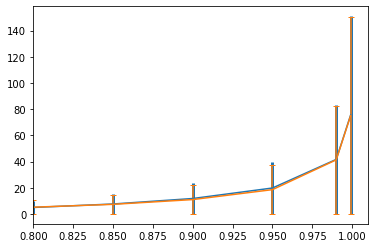

In [50]:
fig, ax = plt.subplots()
ax.errorbar(quants, 86400.*pr1_quantiles, yerr=np.stack([86400.*ci_lower, 86400.*ci_upper]), elinewidth=3)
ax.errorbar(quants, 86400.*pr2_quantiles, yerr=np.stack([86400.*ci_lower2, 86400.*ci_upper2]), capsize=3)
ax.set_xlim([0.8, 1.01])

In [32]:
np.stack([ci_lower, ci_upper]).shape

(2, 21)